# WeatherPy

---

## Starter Code to Generate Random Geographic Coordinates and a List of Cities

In [62]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
from scipy.stats import linregress

# Impor the OpenWeatherMap API key
from api_keys import weather_api_key
#print(weather_api_key)

# Import citipy2 to determine the cities based on latitude and longitude ### SEE NOTE FOR NEW MODULE
import citipy2

### Generate the Cities List by Using the `citipy2` Library

In [63]:
# Empty list for holding the latitude and longitude combinations
lat_lngs = []

# Empty list for holding the cities names
cities = []

# Range of latitudes and longitudes
lat_range = (-90, 90)
lng_range = (-180, 180)

# Create a set of random lat and lng combinations
lats = np.random.uniform(lat_range[0], lat_range[1], size=1500)
lngs = np.random.uniform(lng_range[0], lng_range[1], size=1500)
lat_lngs = zip(lats, lngs)

# Identify nearest city for each lat, lng combination
# AND push the actual lat, lng for those cities into new lists
true_lats = []
true_lngs = []
for lat_lng in lat_lngs:
    city = citipy2.nearest_city(lat_lng[0], lat_lng[1])
    mycityname = city.city_name
    
    # If the city is unique, then add it to a our cities list
    # note: I see that this given code is only taking unique city names. some cities have the same name (Salem, OR vs Salem, MA).
    if mycityname not in cities:
        cities.append(mycityname)
        city_lat = np.float64(float(city.city_lat))
        true_lats.append(city_lat)
        city_lng = np.float64(float(city.city_long))
        true_lngs.append(city_lng)

# Print the city count to confirm sufficient count
print(f"Number of cities in the list: {len(cities)}")

Number of cities in the list: 636


---

## Requirement 1: Create Plots to Showcase the Relationship Between Weather Variables and Latitude

### Use the OpenWeatherMap API to retrieve weather data from the cities list generated in the started code

In [64]:
# Something seemed wrong with the provided code. It is possible that I just mangled it but I was having a hard time with the citypy module.
# The first issue is that the random coordinates were assigned a city, but not corrected to the true coordinates of that city.
# Thus, when I mapped it, the city name appeared next to a dot that was often in the middle of nowhere (like the ocean).
# Also, when I searched for hotels in the next section of the homework, many cities had no hotels because of their distance from anywhere.
# There is a second issue in VSCode where it sometimes (but not always) says that citipy does not have a nearest_city attribute. Sometimes code just stops working.

# I attempted to update the code here to the following logic instead:
# - Get random coordinates
# - Find the nearest city to those coordinates
# - Get the real coordinates for that city
# - Then call the API with real coordinates to get actual weather data for the city, rather than the random coordinates that we selected randomly

# Note: this is also what appears to be necessary to get a result looking like the example map, which has no marks in the ocean, which wouldn't happen with true random coordinates

# Additionally, the citipy module does not have the ability to feed in a city and return coordinates and typing it up on it's own was a pain.
# I thought about contributing that to the citipy module but don't want to break things.
# Instead, I copied the module to a new module and edited that. The new module is citipy2. This puts required features in that module and keeps this notebook cleaner.
# This new module is in the same directory as this notebook, and uses the same csv for data, which I also copied over.
# I am adding this citipy2 module to github so it can be reviewed as part of this work.

# Features added in citipy2:
# 1) city object has latitude and longitude. I use this below.
# 2) created function that takes a city input as a string and returns coordinates (works for the first city in the list, beware duplicates). Used in testing.

In [65]:
# Set the API base URL
url = "https://api.openweathermap.org/data/3.0/onecall?lat={lat}&lon={lon}&exclude={part}&appid={API_key}"

# Define an empty list to fetch the weather data for each city
city_data = []

# Print to logger
print("Beginning Data Retrieval     ")
print("-----------------------------")

# Create counters
record_count = 1
set_count = 1

# Loop through all the cities in our list to fetch weather data
for i, city in enumerate(cities):
        
    # Group cities in sets of 50 for logging purposes
    if (i % 50 == 0 and i >= 50):
        set_count += 1
        record_count = 0

    # Create endpoint URL with each city
 
    mylats = true_lats[i]
  
    mylngs = true_lngs[i]

    # Below is a version that uses the new citipy2 attribute: feeding a city name and getting the real coordinates back.
    # Now when we make the API call we will be calling for the correct coordinates for the city we want.

    city_url = url.format(lat = mylats, lon = mylngs, part = "hourly, daily", API_key = weather_api_key)

    
    # Log the url, record, and set numbers
    print("Processing Record %s of Set %s | %s" % (record_count, set_count, city))

    # Add 1 to the record count
    record_count += 1

    # Run a API request for each of the cities
    try:
        response = requests.get(city_url)
        data = response.json()
        city_weather = data["current"]["weather"][0]["main"] # The [0] here is because it seems like weather was a string? I call the first index of the string then can access the rest as a dict

        # Parse out latitude, longitude, max temp, humidity, cloudiness, wind speed, country, and date
        city_lat = data["lat"]
        city_lng = data["lon"]
        city_max_temp = data["daily"][0]["temp"]["max"] #again using the [0] trick. That was a weird one to figure out.
        city_max_temp = (city_max_temp - 273.15) * 1.8 + 32 # Converting from Kelvin to Farenheit because I got way through this exercise before realizing I should have used imperial. This is easy.
        city_humidity = data["daily"][0]["humidity"]
        city_clouds = data["daily"][0]["clouds"]
        city_wind = data["daily"][0]["wind_speed"]
        city_country = citipy2.nearest_city(city_lat, city_lng).country_code # I had to use a city object in order to pull country, but i only had a list of cities as strings, so i re-create it here. Seems inefficient but I couldn't solve it otherwise.
        city_date = data["current"]["dt"]

        # Append the City information into city_data list
        city_data.append({"City": city, 
                          "Lat": city_lat, 
                          "Lng": city_lng, 
                          "Max Temp": city_max_temp,
                          "Humidity": city_humidity,
                          "Cloudiness": city_clouds,
                          "Wind Speed": city_wind,
                          "Country": city_country,
                          "Date": city_date})
    # If an error is experienced, skip the city
    except:
        print("City not found. Skipping...")
        pass


# Indicate that Data Loading is complete 
print("-----------------------------")
print("Data Retrieval Complete      ")
print("-----------------------------")



Beginning Data Retrieval     
-----------------------------
Processing Record 1 of Set 1 | camana
Processing Record 2 of Set 1 | vaini
Processing Record 3 of Set 1 | vila franca do campo
Processing Record 4 of Set 1 | lompoc
Processing Record 5 of Set 1 | hobart
Processing Record 6 of Set 1 | hilo
Processing Record 7 of Set 1 | shepsi
Processing Record 8 of Set 1 | afmadu
Processing Record 9 of Set 1 | port elizabeth
Processing Record 10 of Set 1 | maceio
Processing Record 11 of Set 1 | rikitea
Processing Record 12 of Set 1 | ojinaga
Processing Record 13 of Set 1 | pangai
Processing Record 14 of Set 1 | bethel
Processing Record 15 of Set 1 | luderitz
Processing Record 16 of Set 1 | longyearbyen
Processing Record 17 of Set 1 | acapulco
Processing Record 18 of Set 1 | qaanaaq
Processing Record 19 of Set 1 | vaitupu
Processing Record 20 of Set 1 | clyde river
Processing Record 21 of Set 1 | leningradskiy
Processing Record 22 of Set 1 | albany
Processing Record 23 of Set 1 | puerto carreno

In [66]:
# Convert the cities weather data into a Pandas DataFrame
city_data_df = pd.DataFrame.from_dict(city_data)

# Show Record Count
city_data_df.count()

City          636
Lat           636
Lng           636
Max Temp      636
Humidity      636
Cloudiness    636
Wind Speed    636
Country       636
Date          636
dtype: int64

In [67]:
# Display sample data
city_data_df.head()

,City,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date
0,camana,-16.6228,-72.7111,75.470,70,54,4.08,pe,1681328842
1,vaini,-21.2000,-175.2000,79.808,73,94,8.34,to,1681328843
2,vila franca do campo,37.7167,-25.4333,64.472,67,100,2.84,pt,1681328843
3,lompoc,34.6392,-120.4569,60.278,65,75,9.00,us,1681328844
4,hobart,-42.8832,147.3317,63.698,55,51,2.16,au,1681328846


In [68]:
# Export the City_Data into a csv
city_data_df.to_csv("../output_data/cities.csv", index_label="City_ID")

In [69]:
# Read saved data
city_data_df = pd.read_csv("../output_data/cities.csv", index_col="City_ID")

# Display sample data
city_data_df.head()

,City,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date
City_ID,,,,,,,,,
0,camana,-16.6228,-72.7111,75.470,70,54,4.08,pe,1681328842
1,vaini,-21.2000,-175.2000,79.808,73,94,8.34,to,1681328843
2,vila franca do campo,37.7167,-25.4333,64.472,67,100,2.84,pt,1681328843
3,lompoc,34.6392,-120.4569,60.278,65,75,9.00,us,1681328844
4,hobart,-42.8832,147.3317,63.698,55,51,2.16,au,1681328846


### Create the Scatter Plots Requested

#### Latitude Vs. Temperature

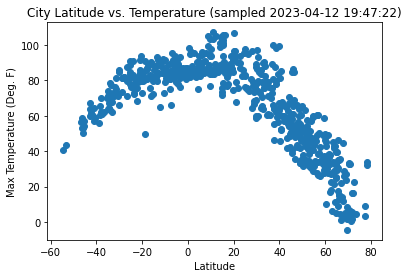

In [70]:
# Build scatter plot for latitude vs. temperature
plt.scatter(city_data_df["Lat"], city_data_df["Max Temp"], marker = "o")

# Incorporate the other graph properties
date_of_sample = pd.to_datetime(city_data_df["Date"], unit = "s")
min_date = date_of_sample.min()
plt.title(f"City Latitude vs. Temperature (sampled {min_date})")
plt.xlabel("Latitude")
plt.ylabel("Max Temperature (Deg. F)")

# Save the figure
plt.savefig("../output_data/Fig1.png")

# Show plot
plt.show()

#### Latitude Vs. Humidity

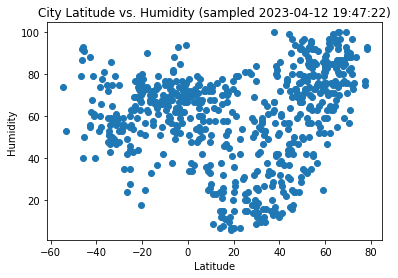

In [71]:
# Build the scatter plots for latitude vs. humidity
plt.scatter(city_data_df["Lat"], city_data_df["Humidity"], marker = "o")

# Incorporate the other graph properties

plt.title(f"City Latitude vs. Humidity (sampled {min_date})")
plt.xlabel("Latitude")
plt.ylabel("Humidity")

# Save the figure
plt.savefig("../output_data/Fig2.png")

# Show plot
plt.show()

#### Latitude Vs. Cloudiness

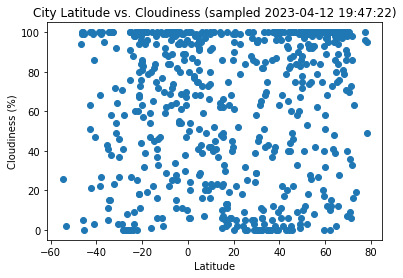

In [72]:
# Build the scatter plots for latitude vs. cloudiness
plt.scatter(city_data_df["Lat"], city_data_df["Cloudiness"], marker = "o")

# Incorporate the other graph properties

plt.title(f"City Latitude vs. Cloudiness (sampled {min_date})")
plt.xlabel("Latitude")
plt.ylabel("Cloudiness (%)")

# Save the figure
plt.savefig("../output_data/Fig3.png")

# Show plot
plt.show()

#### Latitude vs. Wind Speed Plot

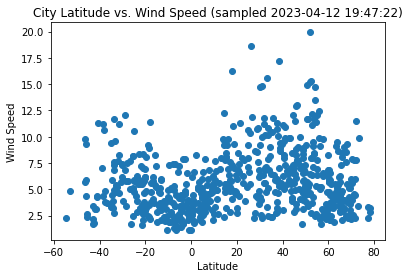

In [73]:
# Build the scatter plots for latitude vs. wind speed
plt.scatter(city_data_df["Lat"], city_data_df["Wind Speed"], marker = "o")

# Incorporate the other graph properties

plt.title(f"City Latitude vs. Wind Speed (sampled {min_date})")
plt.xlabel("Latitude")
plt.ylabel("Wind Speed")
# Save the figure
plt.savefig("../output_data/Fig4.png")

# Show plot
plt.show()

---

## Requirement 2: Compute Linear Regression for Each Relationship


r-value =  0.16196509697200115


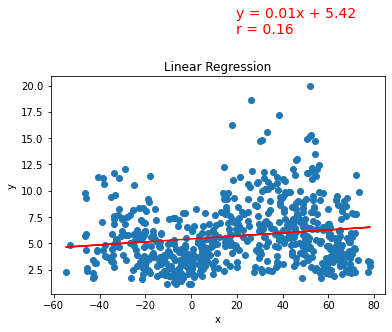

In [74]:
# Define a function to create Linear Regression plots

import math # this is a standard library and I need it for the square root functions

def linear_regression(x, y):
    n = len(x)
    x_mean = sum(x) / n
    y_mean = sum(y) / n
    # calculate R value
    x_stddev = math.sqrt(sum([(i - x_mean)**2 for i in x]) / (len(x) - 1))
    y_stddev = math.sqrt(sum([(i - y_mean)**2 for i in y]) / (len(y) - 1))
    covariance = sum([(x[i] - x_mean) * (y[i] - y_mean) for i in range(len(x))]) / (len(x) - 1)
    r_value = covariance / (x_stddev * y_stddev)
    print("r-value = ", r_value)
    # calculate slope and intercept for plotting
    slope = sum([(x[i] - x_mean) * (y[i] - y_mean) for i in range(n)]) / sum([(x[i] - x_mean) ** 2 for i in range(n)])
    intercept = y_mean - slope * x_mean
    # do the plotting
    plt.scatter(x, y)
    plt.plot(x, [slope * xi + intercept for xi in x], color='red')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Linear Regression')
    # add the equation to the plot
    plt.text(x.mean(),y.max()*1.25,f"y = {slope:.2f}x + {intercept:.2f}\nr = {r_value:.2f}", color='red', size = '14')
    plt.show()


linear_regression(city_data_df["Lat"], city_data_df["Wind Speed"])

r-value = 0.16196509697200118


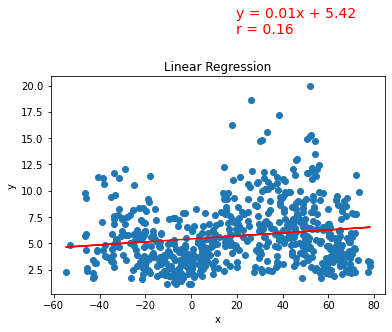

In [75]:
# # Define a function to create Linear Regression plots

def linear_regression(x, y):
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    print("r-value =", r_value)
    plt.scatter(x, y)
    plt.plot(x, slope*x + intercept, color='red')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Linear Regression')
    plt.text(x.mean(), y.max()*1.25, f"y = {slope:.2f}x + {intercept:.2f}\nr = {r_value:.2f}", color='red', size='14')
    plt.show()

linear_regression(city_data_df["Lat"], city_data_df["Wind Speed"])

In [76]:
# Create a DataFrame with the Northern Hemisphere data (Latitude >= 0)
northern_hemi_df = city_data_df[city_data_df["Lat"]>=0]
northern_hemi_df = northern_hemi_df.reset_index(drop=True)


# Display sample data
northern_hemi_df.head()

,City,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date
0,vila franca do campo,37.7167,-25.4333,64.472,67,100,2.84,pt,1681328843
1,lompoc,34.6392,-120.4569,60.278,65,75,9.00,us,1681328844
2,hilo,19.7297,-155.0900,74.750,77,99,4.54,us,1681328846
3,shepsi,44.0355,39.1474,54.050,99,100,3.89,ru,1681328848
4,afmadu,0.5172,42.0711,98.132,34,100,6.21,so,1681328850


In [77]:
# Create a DataFrame with the Southern Hemisphere data (Latitude < 0)
southern_hemi_df = city_data_df[city_data_df["Lat"]<=0]
southern_hemi_df = southern_hemi_df.reset_index(drop=True)


# Display sample data
southern_hemi_df.head()

,City,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date
0,camana,-16.6228,-72.7111,75.470,70,54,4.08,pe,1681328842
1,vaini,-21.2000,-175.2000,79.808,73,94,8.34,to,1681328843
2,hobart,-42.8832,147.3317,63.698,55,51,2.16,au,1681328846
3,port elizabeth,-33.9180,25.5701,68.954,48,100,4.93,za,1681328850
4,maceio,-9.6667,-35.7167,85.460,63,99,4.13,br,1681328851


###  Temperature vs. Latitude Linear Regression Plot

r-value = -0.8915326516926717


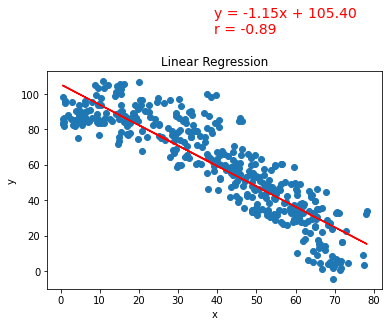

In [88]:
# Linear regression on Northern Hemisphere
linear_regression(northern_hemi_df["Lat"], northern_hemi_df["Max Temp"])


r-value = 0.7611866533712109


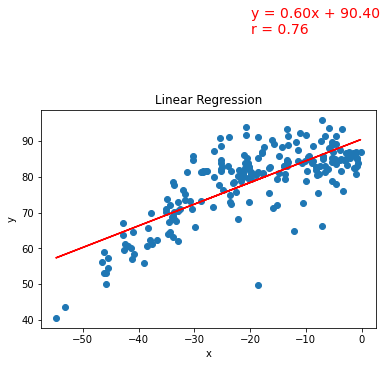

In [79]:
# Linear regression on Southern Hemisphere
linear_regression(southern_hemi_df["Lat"], southern_hemi_df["Max Temp"])

**Discussion about the linear relationship:** YOUR RESPONSE HERE

There is a clear and strong relationship between latitude and temperature. Temperatures are warmer near the equator. We see this in both hemispheres.
There appears to be a stronger relationship in the north (r=0.89) vs the south (r=0.76), but both are strong.

### Humidity vs. Latitude Linear Regression Plot

r-value = 0.44817278377157044


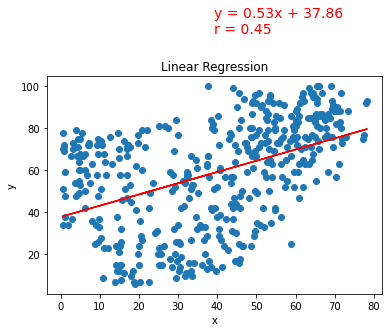

In [80]:
# Northern Hemisphere

linear_regression(northern_hemi_df["Lat"], northern_hemi_df["Humidity"])

r-value = 0.15973218549063642


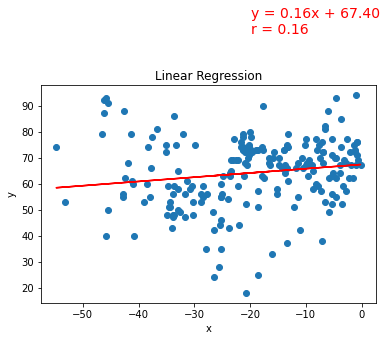

In [81]:
# Southern Hemisphere

linear_regression(southern_hemi_df["Lat"], southern_hemi_df["Humidity"])

**Discussion about the linear relationship:** YOUR RESPONSE HERE

We notice that the global south shows less relationship between the latitude and humidity. with an r of 0.16, very little of the humidity is explained by distance from the equator.
In the north however we see a clear relationship, albeit with a lot of variance. It is less humid overall near the equator than it is further north. Above about 65degN, all of our samples are showing humidity above 50%.

### Cloudiness vs. Latitude Linear Regression Plot

r-value = 0.2453475219745104


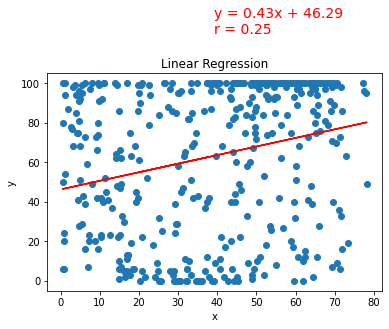

In [82]:
# Northern Hemisphere

linear_regression(northern_hemi_df["Lat"], northern_hemi_df["Cloudiness"])

r-value = 0.13704994523533082


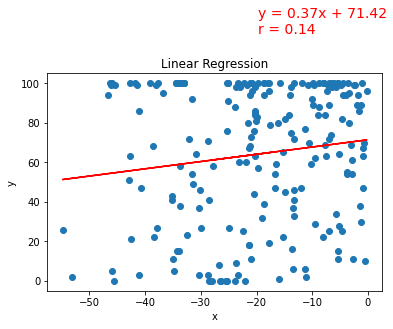

In [86]:
# Southern Hemisphere

linear_regression(southern_hemi_df["Lat"], southern_hemi_df["Cloudiness"])

**Discussion about the linear relationship:** YOUR RESPONSE HERE

We see a slight trend in both hemispheres for cloudiness to increase the further one travels north.
Interestingly, we see some clutering near the 100% mark everywhere, which is expected since 100% is the max possible, and we we also see it near the 0% mark in the 15-45degN range.

### Wind Speed vs. Latitude Linear Regression Plot

r-value = 0.010161132065647293


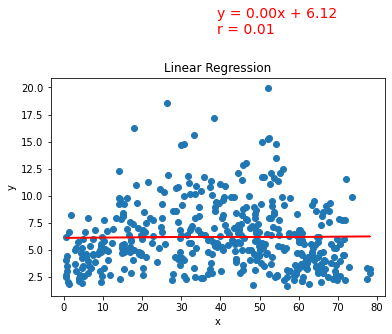

In [84]:
# Northern Hemisphere

linear_regression(northern_hemi_df["Lat"],northern_hemi_df["Wind Speed"])

r-value = -0.3256542157148018


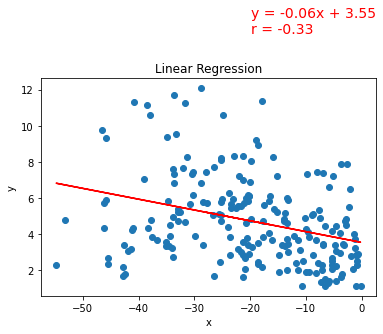

In [85]:
# Southern Hemisphere

linear_regression(southern_hemi_df["Lat"], southern_hemi_df["Wind Speed"])

**Discussion about the linear relationship:** YOUR RESPONSE HERE

The linear relationship here is weak.
In the north, there is no relationship seen between distance from the equator and wind speed.
In the south, distance from the equator appears to explain some of the variance in wind speed. This is however a meaningful relationship in this hemisphere. Wind speeds increase moderately as one gets further south, with about 0.06m/s for every degree.
We also have more samples clustered closer to the waist of the earth.